# Import libraries:

In [385]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation

# Dataset:

In [386]:
df = pd.read_csv("/dataset.csv")
new_df = df.loc[(df['rpt_key'] == 'btc_usd')]
new_df

date_id          datetime_id    market  rpt_key     last  diff_24h  \
3       2017-05-31  2017-06-01 00:00:00  bitstamp  btc_usd  2237.40   2239.37   
4       2017-05-31  2017-06-01 00:00:00    okcoin  btc_usd  2318.82   2228.70   
15      2017-06-01  2017-06-01 00:01:00  bitstamp  btc_usd  2248.39   2242.44   
16      2017-06-01  2017-06-01 00:01:00    okcoin  btc_usd  2320.42   2228.40   
23      2017-06-01  2017-06-01 00:02:00  bitstamp  btc_usd  2248.35   2238.58   
...            ...                  ...       ...      ...      ...       ...   
627164  2017-07-14  2017-07-14 13:16:00    okcoin  btc_usd  2394.03   2500.01   
627173  2017-07-14  2017-07-14 13:17:00  bitstamp  btc_usd  2320.47   2407.06   
627174  2017-07-14  2017-07-14 13:17:00    okcoin  btc_usd  2394.03   2500.01   
627183  2017-07-14  2017-07-14 13:18:00  bitstamp  btc_usd  2320.47   2408.00   
627184  2017-07-14  2017-07-14 13:18:00    okcoin  btc_usd  2394.03   2500.01   

        diff_per_24h      bid      ask      low     high        volume  \
3          -0.087971  2233.09  2237.40  2154.28  2293.46  13681.282017   
4           4.043613  2319.40  2319.99  2129.78  2318.82   4241.641516   
15          0.265336  2247.77  2248.38  2154.28  2293.46  13701.698603   
16          4.129420  2320.99  2321.49  2129.78  2322.00   4260.261516   
23          0.436437  2248.35  2248.69  2154.28  2293.46  13742.110913   
...              ...      ...      ...      ...      ...           ...   
627164     -4.239183  2394.35  2405.72  2378.02  2529.20   1111.540000   
627173     -3.597335  2320.48  2322.55  2307.46  2413.60   7969.263583   
627174     -4.239183  2394.42  2405.69  2378.02  2529.20   1111.540000   
627183     -3.634967  2320.57  2322.55  2307.46  2413.60   7968.970715   
627184     -4.239183  2394.17  2405.69  2378.02  2529.20   1111.221000   

                 created_at           updated_at  
3       2017-05-31 14:59:36  2017-05-31 14:59:36  
4       2017-05-31 14:59:36  2017-05-31 14:59:36  
15      2017-05-31 15:00:36  2017-05-31 15:00:36  
16      2017-05-31 15:00:36  2017-05-31 15:00:36  
23      2017-05-31 15:01:36  2017-05-31 15:01:36  
...                     ...                  ...  
627164  2017-07-14 04:15:20  2017-07-14 04:15:20  
627173  2017-07-14 04:16:20  2017-07-14 04:16:20  
627174  2017-07-14 04:16:20  2017-07-14 04:16:20  
627183  2017-07-14 04:17:20  2017-07-14 04:17:20  
627184  2017-07-14 04:17:20  2017-07-14 04:17:20  

[125438 rows x 14 columns]

In [387]:
new_df = new_df.reset_index(drop=True)
new_df['datetime'] = pd.to_datetime(new_df['datetime_id'])

In [388]:
new_df = new_df[['datetime', 'last', 'diff_24h', 'diff_per_24h', 'bid', 'ask', 'low', 'high', 'volume']]
new_df

datetime     last  diff_24h  diff_per_24h      bid      ask  \
0      2017-06-01 00:00:00  2237.40   2239.37     -0.087971  2233.09  2237.40   
1      2017-06-01 00:00:00  2318.82   2228.70      4.043613  2319.40  2319.99   
2      2017-06-01 00:01:00  2248.39   2242.44      0.265336  2247.77  2248.38   
3      2017-06-01 00:01:00  2320.42   2228.40      4.129420  2320.99  2321.49   
4      2017-06-01 00:02:00  2248.35   2238.58      0.436437  2248.35  2248.69   
...                    ...      ...       ...           ...      ...      ...   
125433 2017-07-14 13:16:00  2394.03   2500.01     -4.239183  2394.35  2405.72   
125434 2017-07-14 13:17:00  2320.47   2407.06     -3.597335  2320.48  2322.55   
125435 2017-07-14 13:17:00  2394.03   2500.01     -4.239183  2394.42  2405.69   
125436 2017-07-14 13:18:00  2320.47   2408.00     -3.634967  2320.57  2322.55   
125437 2017-07-14 13:18:00  2394.03   2500.01     -4.239183  2394.17  2405.69   

            low     high        volume  
0       2154.28  2293.46  13681.282017  
1       2129.78  2318.82   4241.641516  
2       2154.28  2293.46  13701.698603  
3       2129.78  2322.00   4260.261516  
4       2154.28  2293.46  13742.110913  
...         ...      ...           ...  
125433  2378.02  2529.20   1111.540000  
125434  2307.46  2413.60   7969.263583  
125435  2378.02  2529.20   1111.540000  
125436  2307.46  2413.60   7968.970715  
125437  2378.02  2529.20   1111.221000  

[125438 rows x 9 columns]

In [389]:
new_df = new_df[['last']]
dataset = new_df.values
dataset = dataset.astype('float32')

In [390]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [391]:
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = train_test_split(dataset, test_size=test_size, shuffle=False, random_state=42)
print(len(train), len(test))

87806 37632


In [392]:
def create_dataset(dataset, prev_pred=1):
    x = []
    y = []
    
    for i in range(len(dataset) - prev_pred - 1):
        a = dataset[i:(i + prev_pred), 0]
        x.append(a)
        y.append(dataset[i + prev_pred, 0])
    
    x = np.array(x)
    y = np.array(y)
    
    return x, y

#  Linear Regression:

In [393]:
prev_pred = 10
x_train, y_train = create_dataset(train, prev_pred=prev_pred)
x_test, y_test = create_dataset(test, prev_pred=prev_pred)

x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [394]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[2]))
y_test = np.reshape(y_test, (y_test.shape[0], 1))

regressor = LinearRegression()
regressor.fit(x_test, y_test)

LinearRegression()

In [395]:
linear_pred = regressor.predict(x_test)

In [396]:
linear_pred = scaler.inverse_transform(linear_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test)

In [397]:
mae_linear = mean_absolute_error(y_test, linear_pred)
r2_linear = r2_score(y_test, linear_pred)
variance_linear = explained_variance_score(y_test, linear_pred)

print("MAE: ", mae_linear)
print("R2-score: ", r2_linear)
print("Variance score: ", variance_linear)

MAE:  2.6912956
R2-score:  0.9980484179714327
Variance score:  0.9980484247207642


In [398]:
result_LR = pd.DataFrame({'Actual': y_test.flatten(), 'LR_pred': linear_pred.flatten()})
result_LR['Difference'] = result_LR['LR_pred'] - result_LR['Actual']
result_LR

Actual      LR_pred  Difference
0      2445.090088  2444.825928   -0.264160
1      2599.120117  2592.999268   -6.120850
2      2443.040039  2445.334717    2.294678
3      2594.179932  2596.802734    2.622803
4      2448.120117  2443.931641   -4.188477
...            ...          ...         ...
37616  2322.550049  2321.289795   -1.260254
37617  2394.030029  2404.046631   10.016602
37618  2320.469971  2322.458740    1.988770
37619  2394.030029  2396.348145    2.318115
37620  2320.469971  2320.317139   -0.152832

[37621 rows x 3 columns]

In [399]:
fig_LR = go.Figure()
fig_LR.add_trace(go.Scatter(x=result_LR.index, y=result_LR['Actual'], mode='lines', name='Actual'))
fig_LR.add_trace(go.Scatter(x=result_LR.index, y=result_LR['LR_pred'], mode='lines', name='LR_pred'))

fig_LR.update_layout(
    title='Actual vs Predicted for Linear Regression',
    xaxis_title='Index',
    yaxis_title='Value',
    showlegend=True,
    legend=dict(x=0, y=1),
)

fig_LR.show()

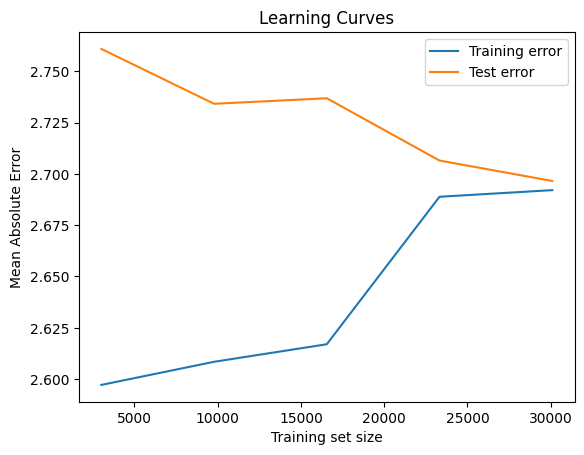

In [400]:
# Cross-validation
train_sizes, train_scores, test_scores = learning_curve(regressor, x_test, y_test, cv=5, scoring='neg_mean_absolute_error')

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

# Plot learning curves
fig, ax = plt.subplots()
ax.plot(train_sizes, train_scores_mean, label='Training error')
ax.plot(train_sizes, test_scores_mean, label='Test error')
ax.set_xlabel('Training set size')
ax.set_ylabel('Mean Absolute Error')
ax.set_title('Learning Curves')
ax.legend()
plt.show()

## LSTM

In [401]:
prev_pred = 10
x_train, y_train = create_dataset(train, prev_pred=prev_pred)
x_test, y_test = create_dataset(test, prev_pred=prev_pred)

x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [402]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, prev_pred)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(x_train, y_train, epochs=10, batch_size=128, verbose=2)

Epoch 1/10
686/686 - 6s - loss: 0.0240 - 6s/epoch - 8ms/step
Epoch 2/10
686/686 - 3s - loss: 3.0031e-04 - 3s/epoch - 4ms/step
Epoch 3/10
686/686 - 3s - loss: 1.1952e-04 - 3s/epoch - 4ms/step
Epoch 4/10
686/686 - 2s - loss: 9.1441e-05 - 2s/epoch - 3ms/step
Epoch 5/10
686/686 - 2s - loss: 7.6781e-05 - 2s/epoch - 3ms/step
Epoch 6/10
686/686 - 2s - loss: 6.8761e-05 - 2s/epoch - 3ms/step
Epoch 7/10
686/686 - 3s - loss: 6.1977e-05 - 3s/epoch - 4ms/step
Epoch 8/10
686/686 - 3s - loss: 5.5253e-05 - 3s/epoch - 4ms/step
Epoch 9/10
686/686 - 2s - loss: 4.8807e-05 - 2s/epoch - 3ms/step
Epoch 10/10
686/686 - 2s - loss: 4.3204e-05 - 2s/epoch - 3ms/step


In [403]:
pred_LSTM = model.predict(x_test)

1176/1176 [==============================] - 3s 2ms/step


In [404]:
pred_LSTM = scaler.inverse_transform(pred_LSTM)
y_test = scaler.inverse_transform([y_test])

In [405]:
mae_test = mean_absolute_error(y_test[0], pred_LSTM[:, 0])
r2_test = r2_score(y_test[0], pred_LSTM[:, 0])
variance_test = explained_variance_score(y_test[0], pred_LSTM[:, 0])

print("MAE: ", mae_test)
print("R2-score: ", r2_test)
print("Variance score: ", variance_test)

MAE:  5.382907192492204
R2-score:  0.9944715743588604
Variance score:  0.9947559059397972


In [406]:
result_LSTM = pd.DataFrame({'Actual': y_test.flatten(), 'pred_LSTM': pred_LSTM.flatten()})
result_LSTM['Difference'] = result_LSTM['pred_LSTM'] - result_LSTM['Actual']
result_LSTM

Actual    pred_LSTM  Difference
0      2445.090141  2445.563721    0.473580
1      2599.120183  2586.595215  -12.524969
2      2443.040124  2445.533447    2.493324
3      2594.180041  2588.874512   -5.305529
4      2448.120209  2445.588623   -2.531586
...            ...          ...         ...
37616  2322.549956  2338.386719   15.836762
37617  2394.030134  2401.868896    7.838762
37618  2320.469968  2338.925293   18.455325
37619  2394.030134  2405.578125   11.547991
37620  2320.469968  2337.062744   16.592777

[37621 rows x 3 columns]

In [407]:
fig_lstm = go.Figure()
fig_lstm.add_trace(go.Scatter(x=result_LSTM.index, y=result_LSTM['Actual'], mode='lines', name='Actual'))
fig_lstm.add_trace(go.Scatter(x=result_LSTM.index, y=result_LSTM['pred_LSTM'], mode='lines', name='pred_LSTM'))

fig_lstm.update_layout(
    title='Actual vs Predicted for LSTM',
    xaxis_title='Index',
    yaxis_title='Value',
    showlegend=True,
    legend=dict(x=0, y=1),
)

fig_lstm.show()


# Random Forest:

In [408]:
prev_pred = 10
x_train, y_train = create_dataset(train, prev_pred=prev_pred)
x_test, y_test = create_dataset(test, prev_pred=prev_pred)

x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [409]:
rf_model = RandomForestRegressor()

In [410]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1] * x_train.shape[2]))

rf_model.fit(x_train, y_train)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] * x_test.shape[2]))

rf_pred = rf_model.predict(x_test)

In [411]:
rf_pred = scaler.inverse_transform(rf_pred.reshape(-1, 1)).flatten()
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

In [412]:
mae_rf = mean_absolute_error(y_test, rf_pred)
r2_rf = r2_score(y_test, rf_pred)
variance_rf = explained_variance_score(y_test, rf_pred)

print("Random Forest Results:")
print("MAE: ", mae_rf)
print("R2-score: ", r2_rf)
print("Variance score: ", variance_rf)

Random Forest Results:
MAE:  3.0609013752092435
R2-score:  0.9976688167811927
Variance score:  0.9976738109276362


In [413]:
result_RF = pd.DataFrame({'Actual': y_test.flatten(), 'RF_pred': rf_pred.flatten()})
result_RF['Difference'] = result_RF['RF_pred'] - result_RF['Actual']
result_RF

Actual      RF_pred  Difference
0      2445.090088  2443.600740   -1.489348
1      2599.120117  2592.365667   -6.754451
2      2443.040039  2444.010877    0.970838
3      2594.179932  2596.436011    2.256079
4      2448.120117  2442.114481   -6.005636
...            ...          ...         ...
37616  2322.550049  2323.154282    0.604233
37617  2394.030029  2405.305693   11.275663
37618  2320.469971  2322.461571    1.991601
37619  2394.030029  2394.280267    0.250238
37620  2320.469971  2322.875787    2.405816

[37621 rows x 3 columns]

In [414]:
fig_RF = go.Figure()
fig_RF.add_trace(go.Scatter(x=result_RF.index, y=result_RF['Actual'], mode='lines', name='Actual'))
fig_RF.add_trace(go.Scatter(x=result_RF.index, y=result_RF['RF_pred'], mode='lines', name='RF_pred'))

fig_RF.update_layout(
    title='Actual vs Predicted for Random Forest',
    xaxis_title='Index',
    yaxis_title='Value',
    showlegend=True,
    legend=dict(x=0, y=1),
)

fig_RF.show()

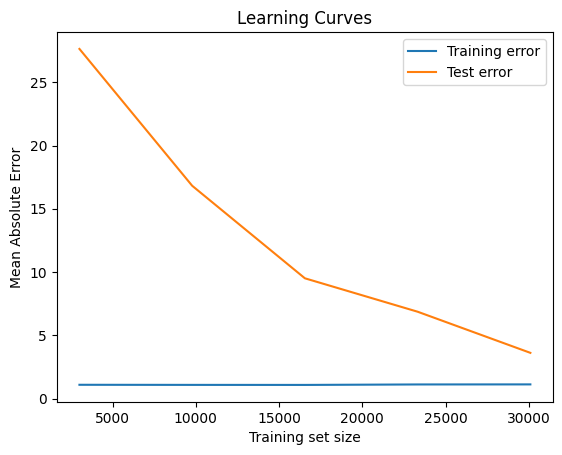

In [415]:
# Cross-validation
train_sizes, train_scores, test_scores = learning_curve(rf_model, x_test, y_test, cv=5, scoring='neg_mean_absolute_error')

train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

# Plot learning curves
fig, ax = plt.subplots()
ax.plot(train_sizes, train_scores_mean, label='Training error')
ax.plot(train_sizes, test_scores_mean, label='Test error')
ax.set_xlabel('Training set size')
ax.set_ylabel('Mean Absolute Error')
ax.set_title('Learning Curves')
ax.legend()
plt.show()

# Comparison of model results:

In [416]:
result = pd.DataFrame({'Actual': y_test.flatten(), 'LR_pred': linear_pred.flatten(), 
                       'LSTM_pred': pred_LSTM.flatten(), 'RF_pred': rf_pred.flatten()})
result 

Actual      LR_pred    LSTM_pred      RF_pred
0      2445.090088  2444.825928  2445.563721  2443.600740
1      2599.120117  2592.999268  2586.595215  2592.365667
2      2443.040039  2445.334717  2445.533447  2444.010877
3      2594.179932  2596.802734  2588.874512  2596.436011
4      2448.120117  2443.931641  2445.588623  2442.114481
...            ...          ...          ...          ...
37616  2322.550049  2321.289795  2338.386719  2323.154282
37617  2394.030029  2404.046631  2401.868896  2405.305693
37618  2320.469971  2322.458740  2338.925293  2322.461571
37619  2394.030029  2396.348145  2405.578125  2394.280267
37620  2320.469971  2320.317139  2337.062744  2322.875787

[37621 rows x 4 columns]

In [417]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=result.index, y=result['Actual'], mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=result.index, y=result['LR_pred'], mode='lines', name='LR_pred'))
fig.add_trace(go.Scatter(x=result.index, y=result['LSTM_pred'], mode='lines', name='LSTM_pred'))
fig.add_trace(go.Scatter(x=result.index, y=result['RF_pred'], mode='lines', name='RF_pred'))

fig.update_layout(
    title='Actual vs Predicted for Linear Regression',
    xaxis_title='Index',
    yaxis_title='Value',
    showlegend=True,
    legend=dict(x=0, y=1),
)

fig.show()